# Exploratory Analysis of UIDAI Activity Data

## Objective
This notebook performs exploratory analysis on the cleaned, district-level UIDAI datasets covering:
- Aadhaar Enrolments
- Demographic Updates
- Biometric Updates

The purpose of this analysis is to:
- Validate data coverage and consistency
- Understand temporal and geographic patterns
- Examine distributional characteristics and inequality
- Build intuition for downstream stress and lifecycle analyses

## Step 1: Load Cleaned Datasets

We begin by loading the finalized, district-level datasets generated in Notebook 1.  
All subsequent analysis is conducted exclusively on these cleaned files.

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

enrol = pd.read_csv("../data/processed/enrolment_clean.csv", parse_dates=["date"])
demo  = pd.read_csv("../data/processed/demographic_updates_clean.csv", parse_dates=["date"])
bio   = pd.read_csv("../data/processed/biometric_updates_clean.csv", parse_dates=["date"])

## Step 2: Data Coverage and Completeness Checks

Basic coverage checks are performed to validate dataset integrity before exploratory analysis.
These checks focus on:
- Missing values
- Presence of zero-activity records
- Temporal and geographic coverage

### a. Missing Values Check

In [51]:
missing_df = pd.concat(
    [
        enrol.isna().sum().rename("Enrolment"),
        demo.isna().sum().rename("Demographic Updates"),
        bio.isna().sum().rename("Biometric Updates")
    ],
    axis=1
)

missing_df

,Enrolment,Demographic Updates,Biometric Updates
date,0.0,0.0,0.0
state,0.0,0.0,0.0
district,0.0,0.0,0.0
age_0_5,0.0,NaN,NaN
age_5_17,0.0,NaN,NaN
age_18_greater,0.0,NaN,NaN
demo_age_5_17,NaN,0.0,NaN
demo_age_17_plus,NaN,0.0,NaN
bio_age_5_17,NaN,NaN,0.0
bio_age_17_plus,NaN,NaN,0.0


**No missing values found.**

### b. Zero Value Proportions: 

The following check quantifies the proportion of district–date records with zero reported activity across age groups, to distinguish structural inactivity from data quality issues.

In [52]:
zero_df = pd.concat(
    [
        (enrol[["age_0_5","age_5_17","age_18_greater"]] == 0)
            .mean()
            .rename("Enrolment"),
        
        (demo[["demo_age_5_17","demo_age_17_plus"]] == 0)
            .mean()
            .rename("Demographic Updates"),
        
        (bio[["bio_age_5_17","bio_age_17_plus"]] == 0)
            .mean()
            .rename("Biometric Updates")
    ],
    axis=1
)

(zero_df * 100).round(1)

,Enrolment,Demographic Updates,Biometric Updates
age_0_5,3.0,NaN,NaN
age_5_17,14.2,NaN,NaN
age_18_greater,71.4,NaN,NaN
demo_age_5_17,NaN,12.3,NaN
demo_age_17_plus,NaN,0.3,NaN
bio_age_5_17,NaN,NaN,5.4
bio_age_17_plus,NaN,NaN,1.4


**Observed zero rates align with expected lifecycle patterns, particularly lower-frequency adult enrolment and episodic child update activity.**

## Step 3: Temporal Coverage

This section examines how UIDAI activity is distributed over time.
Understanding reporting frequency and temporal spread is important for interpreting later trends and anomalies.

In [53]:
def temporal_summary(df, name):
    return {
        "Dataset": name,
        "Start Date": df["date"].min().date(),
        "End Date": df["date"].max().date(),
        "Reporting Days": df["date"].nunique()
    }

temporal_df = pd.DataFrame([
    temporal_summary(enrol, "Enrolment"),
    temporal_summary(demo, "Demographic Updates"),
    temporal_summary(bio, "Biometric Updates")
])

print("The table below summarizes the temporal reporting span and frequency for each dataset:\n")
display(temporal_df)

The table below summarizes the temporal reporting span and frequency for each dataset:



,Dataset,Start Date,End Date,Reporting Days
0,Enrolment,2025-01-04,2025-12-11,30
1,Demographic Updates,2025-01-03,2025-12-12,41
2,Biometric Updates,2025-01-03,2025-12-12,41


### Observations:

- All three datasets exhibit **consistent year-wide coverage** through these reporting periods, enabling valid cross-district and cross-lifecycle comparisons.

- **Enrolment activity** is recorded on **fewer operational dates**, consistent with campaign- or drive-based enrolment processes.

- In contrast, **demographic and biometric updates** exhibit **more frequent reporting**, reflecting their role as ongoing system maintenance activities.

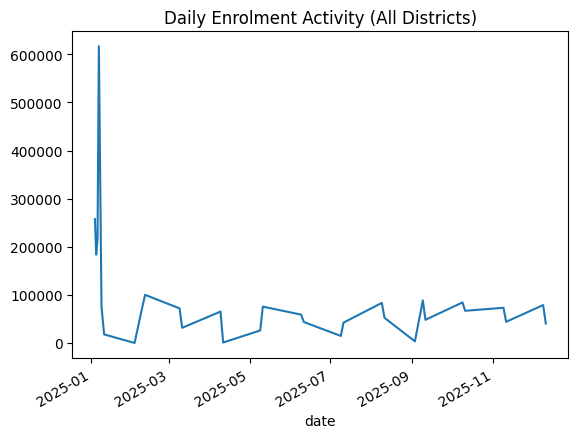

In [54]:
enrol_daily = enrol.groupby("date")[["age_0_5","age_5_17","age_18_greater"]].sum().sum(axis=1)
enrol_daily.plot(title="Daily Enrolment Activity (All Districts)")
plt.show()

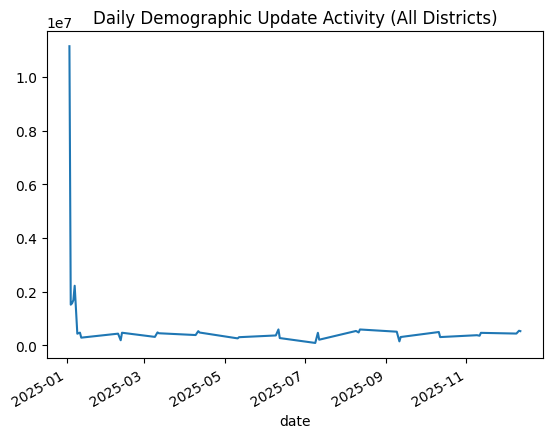

In [55]:
demo_update_daily = demo.groupby("date")[["demo_age_5_17","demo_age_17_plus"]].sum().sum(axis=1)
demo_update_daily.plot(title="Daily Demographic Update Activity (All Districts)")
plt.show()

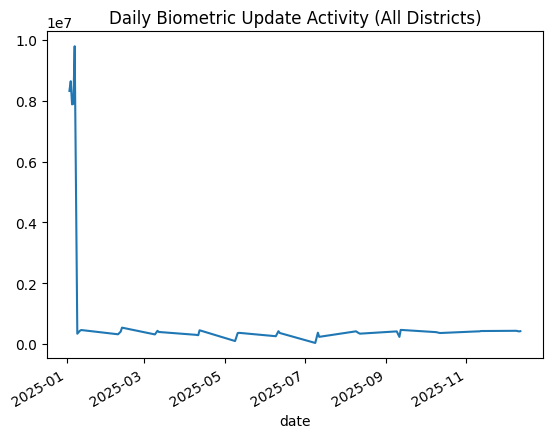

In [56]:
bio_update_daily = bio.groupby("date")[["bio_age_5_17","bio_age_17_plus"]].sum().sum(axis=1)
bio_update_daily.plot(title="Daily Biometric Update Activity (All Districts)")
plt.show()

### Observations: 

- All three datasets exhibit a **pronounced activity spike early in the year**, followed by relatively stable reporting volumes. 

- The **alignment of this spike** across enrolment, demographic updates, and biometric updates suggests a **system-wide reporting or backlog consolidation event** rather than dataset-specific anomalies.

## Step 4: Distribution of Activity Across Districts

We examine how activity is distributed across districts by aggregating counts over time.
This helps identify skewness, concentration, and long-tail behavior in UIDAI operations.

In [57]:
enrol_district_total = enrol.groupby("district")[["age_0_5","age_5_17","age_18_greater"]].sum().sum(axis=1)
demo_district_total  = demo.groupby("district")[["demo_age_5_17","demo_age_17_plus"]].sum().sum(axis=1)
bio_district_total   = bio.groupby("district")[["bio_age_5_17","bio_age_17_plus"]].sum().sum(axis=1)

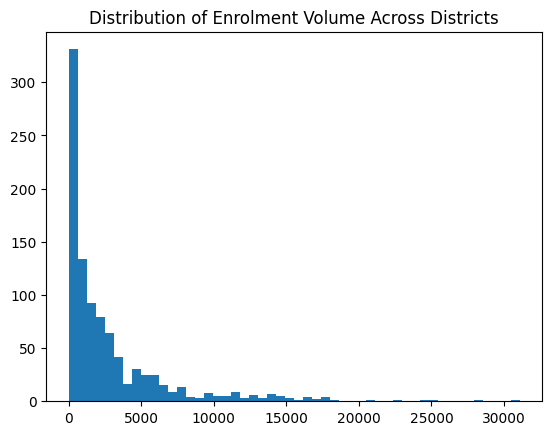

In [58]:
plt.hist(enrol_district_total, bins=50)
plt.title("Distribution of Enrolment Volume Across Districts")
plt.show()

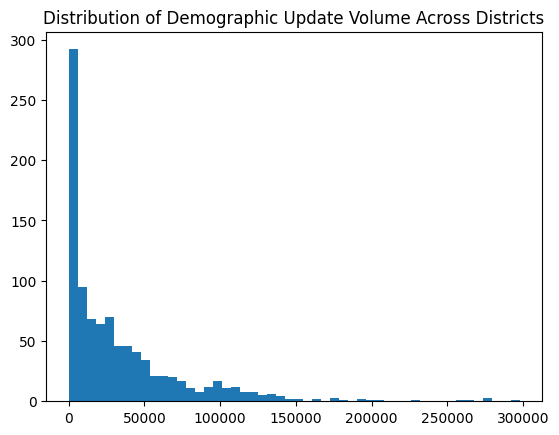

In [59]:
plt.hist(demo_district_total, bins=50)
plt.title("Distribution of Demographic Update Volume Across Districts")
plt.show()

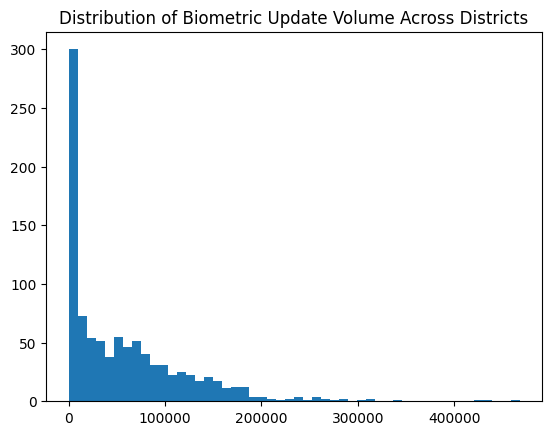

In [60]:
plt.hist(bio_district_total, bins=50)
plt.title("Distribution of Biometric Update Volume Across Districts")
plt.show()

### Observations:

- Across enrolment, demographic update, and biometric update datasets, district-level activity exhibits a **strongly right-skewed distribution**.
  
- Most districts contribute relatively low volumes, while a small subset accounts for disproportionately high activity.
  
- The consistency of this distributional pattern across lifecycle stages suggests **structural concentration of UIDAI system load, motivating focused stress and prioritization analyses** in subsequent notebooks.

## Step 5: Cross-Dataset Scale Comparison

This section **compares the overall scale and variability** of enrolment, demographic update, and biometric update activity.
The objective is to understand how different lifecycle stages contribute to system load.

In [61]:
comparison_df = pd.DataFrame({
    "Enrolment": enrol_district_total,
    "Demographic Updates": demo_district_total,
    "Biometric Updates": bio_district_total
})

comparison_df.describe()

,Enrolment,Demographic Updates,Biometric Updates
count,954.000000,958.000000,963.000000
mean,2765.191824,33895.364301,57680.470405
std,3951.614512,42245.196307,64386.244228
min,1.000000,1.000000,1.000000
25%,339.500000,3576.500000,5212.000000
50%,1315.000000,19599.500000,38945.000000
75%,3337.500000,47145.000000,87389.500000
max,31073.000000,297650.000000,467903.000000


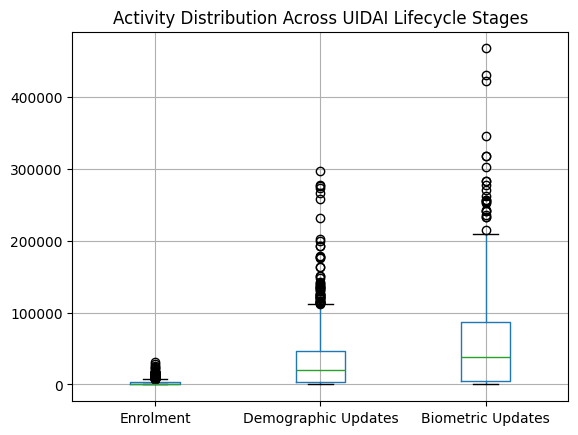

In [62]:
comparison_df.boxplot()
plt.title("Activity Distribution Across UIDAI Lifecycle Stages")
plt.show()

### Observations:

- District-level activity volumes increase sharply across UIDAI lifecycle stages.
   
- While enrolment activity remains relatively modest and tightly distributed, both demographic and biometric updates exhibit substantially higher volumes and greater variability.

- The widening spread and heavier upper tails for update activity indicate that a small subset of districts bears a disproportionate share of ongoing system load.

- This structural amplification across lifecycle stages motivates focused stress detection and prioritization analyses in subsequent sections.

## Step 6: Geographic Coverage and Context

This section provides a high-level geographic view of UIDAI activity.
Visualizations here are intended for context, not detailed spatial analysis.

In [63]:
top_states = (
    enrol["state"]
    .value_counts()
    .head(10)
    .rename_axis("State")
    .reset_index(name="Enrolment Volume")
)

top_states

,State,Enrolment Volume
0,Uttar Pradesh,2114
1,Madhya Pradesh,1483
2,Maharashtra,1160
3,Karnataka,1124
4,Bihar,1092
5,Andhra Pradesh,987
6,Tamil Nadu,952
7,Gujarat,947
8,West Bengal,932
9,Assam,913


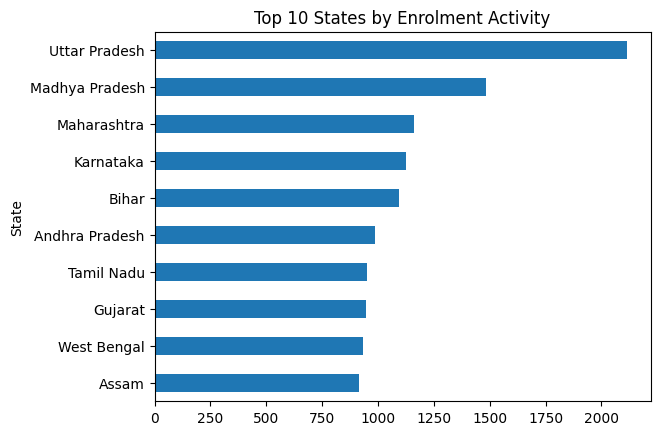

In [64]:
top_states.plot(
    x="State",
    y="Enrolment Volume",
    kind="barh",
    title="Top 10 States by Enrolment Activity",
    legend=False
)
plt.gca().invert_yaxis()
plt.show()

### Observation:

State-level aggregation confirms that UIDAI activity is nationally distributed, with **higher volumes concentrated in a small number of populous and administratively dense states.**
This geographic concentration aligns with the district-level inequality observed earlier.

## Step 7: Age Cohort Participation Patterns

We examine how activity is distributed across age cohorts within each dataset.
This provides early insight into lifecycle participation and transition behavior.


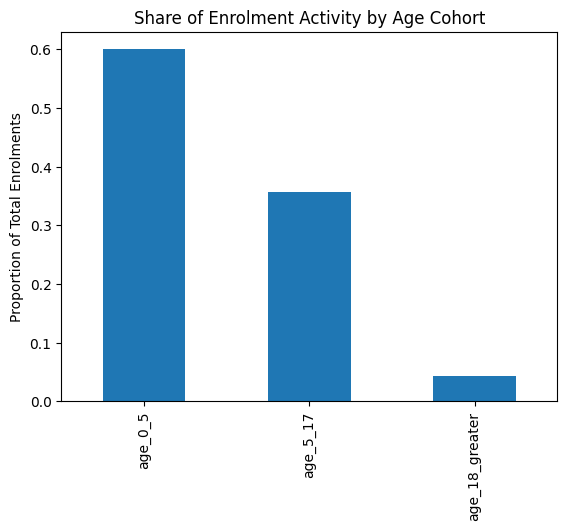

In [65]:
enrol_age_share = enrol[["age_0_5","age_5_17","age_18_greater"]].sum()
enrol_age_pct = enrol_age_share / enrol_age_share.sum()

enrol_age_pct.plot(
    kind="bar",
    title="Share of Enrolment Activity by Age Cohort"
)
plt.ylabel("Proportion of Total Enrolments")
plt.show()

### Observation:

Enrolment activity is heavily concentrated in the 0–5 age cohort, reflecting Aadhaar’s role as an early-life identity system.
Enrolments among adults are comparatively rare, indicating that most adult participation occurs through updates rather than initial registration.

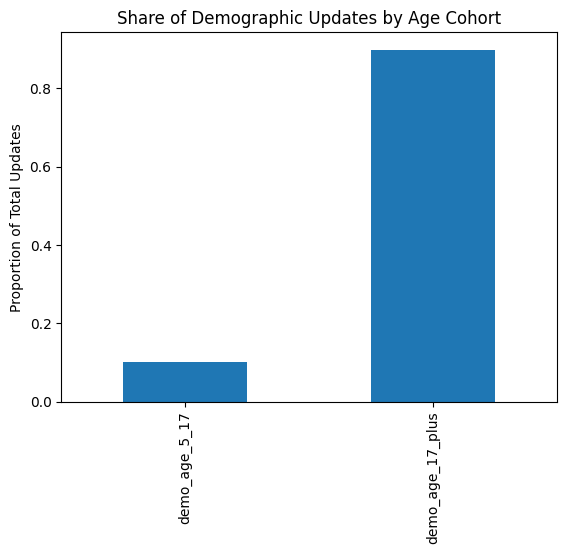

In [66]:
demo_age_share = demo[["demo_age_5_17", "demo_age_17_plus"]].sum()

demo_age_pct = demo_age_share / demo_age_share.sum()

demo_age_pct.plot(
    kind="bar",
    title="Share of Demographic Updates by Age Cohort"
)
plt.ylabel("Proportion of Total Updates")
plt.show()

### Observation:

- Demographic update activity is dominated by adult cohorts, reflecting Aadhaar’s role as a continuously maintained identity system beyond initial enrolment. 
- In contrast to enrolment, update-driven lifecycle stages generate sustained and higher-volume system interactions.

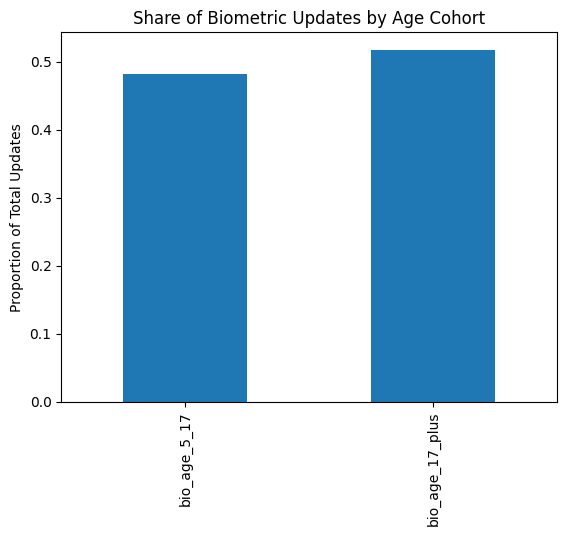

In [67]:
bio_age_share = bio[["bio_age_5_17", "bio_age_17_plus"]].sum()

bio_age_pct = bio_age_share / bio_age_share.sum()

bio_age_pct.plot(
    kind="bar",
    title="Share of Biometric Updates by Age Cohort"
)
plt.ylabel("Proportion of Total Updates")
plt.show()

### Observation:

- Biometric update activity is distributed across both 5–17 and 17+ cohorts.

- This reflects Aadhaar’s lifecycle design, where biometric capture begins after early childhood and is subsequently revalidated during adolescence and adulthood.

- The near balance between cohorts highlights that biometric updates are not one-time events, but recurring lifecycle-driven interactions that contribute substantially to sustained system load.

## Conclusion:

A small number of consistent patterns emerge across all three UIDAI datasets:

- UIDAI activity is **not uniformly distributed**. Across enrolment, demographic updates, and biometric updates, most districts contribute modest volumes while a small subset accounts for disproportionately high activity.
- **Update-driven lifecycle stages** generate **far greater and more variable system load** than initial enrolment, particularly for adult cohorts.
- Age-cohort participation closely follows Aadhaar’s lifecycle logic: enrolment is concentrated in early childhood, while demographic and biometric updates dominate in adolescence and adulthood.
- Biometric updates exhibit sustained participation across age groups, reinforcing their role as recurring, lifecycle-driven interactions rather than one-time events.

Taken together, these observations suggest that UIDAI system pressure is **concentrated, lifecycle-driven, and geographically uneven**.

The next phase of analysis builds directly on this foundation by:
- identifying districts experiencing disproportionate operational stress, and
- highlighting regions where lifecycle participation appears delayed or incomplete.